<h1><center>Taxi Service Centers</center></h1>
<h3><center>Geolocation clustering to find Taxi Service Centers</center></h3>

Taxi's are one of the most popular means of transportation in every city. It is benefits millions of people daily either via commute or employment. A taxi rank is a place where the taxi's wait for customers. Many cities have a designated spot and other cities have random places where taxi's accumulate. For example, many taxi's wait outside Airports, Train stations or Business parks as compared to near housing societies. 

The task is to pin point locations where service centers can be built to accomodate as many as taxis as possible. The dataset used is of the city Johannesburg in South Africa. The dataset contains 3 columns - Name of the taxi locations and its latitude and longitude.

The taxi locations will be clustered. The easier choice would be to build the service center at the centroid of each cluster as it would service all the taxis within the cluster area.

Importing necessary libraries and data.

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from ipywidgets import interactive
from collections import defaultdict
from yellowbrick.cluster import KElbowVisualizer
from plotly.colors import DEFAULT_PLOTLY_COLORS, PLOTLY_SCALES
import folium
import re
import hdbscan
import tqdm
import random

In [168]:
l = """aliceblue, antiquewhite, aqua, aquamarine, azure,
beige, bisque, black, blanchedalmond, blue,
blueviolet, brown, burlywood, cadetblue,
chartreuse, chocolate, coral, cornflowerblue,
cornsilk, crimson, cyan, darkblue, darkcyan,
darkgoldenrod, darkgray, darkgrey, darkgreen,
darkkhaki, darkmagenta, darkolivegreen, darkorange,
darkorchid, darkred, darksalmon, darkseagreen,
darkslateblue, darkslategray, darkslategrey,
darkturquoise, darkviolet, deeppink, deepskyblue,
dimgray, dimgrey, dodgerblue, firebrick,
floralwhite, forestgreen, fuchsia, gainsboro,
ghostwhite, gold, goldenrod, gray, grey, green,
greenyellow, honeydew, hotpink, indianred, indigo,
ivory, khaki, lavender, lavenderblush, lawngreen,
lemonchiffon, lightblue, lightcoral, lightcyan,
lightgoldenrodyellow, lightgray, lightgrey,
lightgreen, lightpink, lightsalmon, lightseagreen,
lightskyblue, lightslategray, lightslategrey,
lightsteelblue, lightyellow, lime, limegreen,
linen, magenta, maroon, mediumaquamarine,
mediumblue, mediumorchid, mediumpurple,
mediumseagreen, mediumslateblue, mediumspringgreen,
mediumturquoise, mediumvioletred, midnightblue,
mintcream, mistyrose, moccasin, navajowhite, navy,
oldlace, olive, olivedrab, orange, orangered,
orchid, palegoldenrod, palegreen, paleturquoise,
palevioletred, papayawhip, peachpuff, peru, pink,
plum, powderblue, purple, red, rosybrown,
royalblue, saddlebrown, salmon, sandybrown,
seagreen, seashell, sienna, silver, skyblue,
slateblue, slategray, slategrey, snow, springgreen,
steelblue, tan, teal, thistle, tomato, turquoise,
violet, wheat, white, whitesmoke, yellow,
yellowgreen""".split(',')

colors = [s.replace('\n','').strip() for s in l]
random.shuffle(colors)

In [8]:
df = pd.read_csv('./taxi_data.csv')
df.head(5)

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

There are not many columns. Before the problem statement is dealt with, it is important to check if the data is clean. For this, the duplicates and null values are checked. Since the focus is on Latitude and Longitude values, only they are considered.

In [15]:
print("duplicates ",df.duplicated(subset=['LON','LAT']).sum())
print("null values\n",df.isna().sum())

duplicates  14
null values
 LON     1
LAT     1
NAME    1
dtype: int64


In [18]:
df.dropna(inplace=True)
df.drop_duplicates(subset= ['LON','LAT'], keep= 'first', inplace= True)

Before going into clustering, it is important to view the data first. So the locations are plotted on a map first to understand dense and sparse regions.

In [33]:
mapf = folium.Map(
    location= [df.LAT.mean(), df.LON.mean()],
    zoom_start= 9,
    tiles= 'Stamen Toner',
    height= 550
)

tmp = df.apply(
    lambda row: folium.CircleMarker(
        location= [row.LAT, row.LON],
        radius= 3,
        popup= re.sub(r'[^a-zA-Z ]+','',row.NAME),
        color= '#009999',
        fill= True,
        fill_color= '#009999'
    ).add_to(mapf),
    axis= 1
)
mapf

The first clustering approach used is the Kmeans algorithm. The Kmeans algorithm simple assign a point to a cluster if the distance is minimum to it. The first step is to find the optimal number of clusters. There are two methods, one is to manually fit kmeans model on different k values and compare the silhouette score, the other technique is to use a KElbowVisualizer function, which performs the above step automatically and plots a graph giving us the optimal number of clusters.<br>

First it is done manually.

In [49]:
def kmeans_fit(data, k):
    model = KMeans(n_clusters= k, random_state= 5, n_jobs= -1, verbose= 1)
    model.fit(np.array(data[['LAT','LON']]))
    return model
    
score = 0
k = 0

for i in tqdm.tqdm(range(2,200)):
    mod = kmeans_fit(df,i)
    pred = mod.predict(np.array(df[['LAT','LON']]))
    s = silhouette_score(np.array(df[['LAT','LON']]),pred)
    if s > score:
        score = s
        k = i
print(f"Best score = {score} for clusters {k}")

100%|██████████| 198/198 [00:44<00:00,  4.43it/s]

Best score = 0.7503653862491605 for clusters 199


The results show that about 199 clusters are the optimal number of clusters, acheiving  the best silhouette score. Next is to try the visualizer, which can graphically show what was done manually previously.

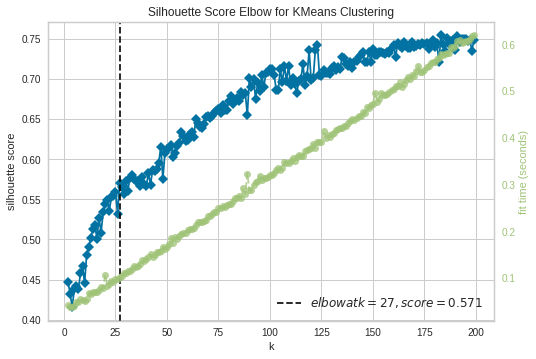

In [51]:
model = KMeans(n_init= 10)
visualizer = KElbowVisualizer(model, k= (2,200), metric= 'silhouette')
visualizer.fit(df[['LAT','LON']])
visualizer.show()

The plot suggests that 27 be the optimal cluster keeping in mind the score as well as fit time and complexity.
This value is now used to generate the final KMeans model and plot the results on a map.

In [52]:
model = KMeans(n_clusters= 27, n_init= 10, random_state= 5, n_jobs= -1, verbose= 1)
model.fit(np.array(df[['LAT','LON']]))
pred = model.predict(np.array(df[['LAT','LON']]))
df['CLUSTER_kmeans'] = pred
df.head(5)

LON       LAT                          NAME  CLUSTER_kmeans
0  28.17858 -25.73882         11th Street Taxi Rank              16
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank              16
2  27.83239 -26.53722          Adams Road Taxi Rank               9
3  28.12514 -26.26666  Alberton City Mall Taxi Rank               3
4  28.10144 -26.10567      Alexandra Main Taxi Rank               6

In [61]:
mapf = folium.Map(
    location= [df.LAT.mean(), df.LON.mean()],
    zoom_start= 9,
    tiles= 'Stamen Toner',
    height= 550
)

tmp = df.apply(
    lambda row: folium.CircleMarker(
        location= [row.LAT, row.LON],
        radius= 3,
        popup= row.CLUSTER_kmeans,
        color= colors[row.CLUSTER_kmeans],
        fill= True,
        fill_color= colors[row.CLUSTER_kmeans],
    ).add_to(mapf),
    axis= 1
)
mapf

The 27 clusters formed are plotted on the map. The clusters are not so well defined and maybe it can be said that 27 service centers at the centroid of these clusters maybe too few to handle. This is because every Taxi rank hold a number of Taxis. If the cluster has more than 10 Ranks within, then the number of taxis for service center to handle is too large.<br>

Keeping in mind the above reasoning, complex clustering algorithms are further applied. The DBSCAN (Density Based Spatial Clustering Application with Noise) is a type of clustering which instead of using calculating distance and then bunching up the nearest points, uses density based approach, where points that are density reachable are combined.

In [105]:
model = DBSCAN(eps= 0.01, min_samples=5).fit(df[['LAT','LON']])
df['CLUSTER_dbscan'] = model.labels_

mapf = folium.Map(
    location= [df.LAT.mean(), df.LON.mean()],
    zoom_start= 9,
    tiles= 'Stamen Toner',
    height= 550
)

tmp = df.apply(
    lambda row: folium.CircleMarker(
        location= [row.LAT, row.LON],
        radius= 3,
        popup= row.CLUSTER_dbscan,
        color= [colors[row.CLUSTER_dbscan] if row.CLUSTER_dbscan != -1 else '#00000F'],
        fill= True,
        fill_color= [colors[row.CLUSTER_dbscan] if row.CLUSTER_dbscan != -1 else '#00000F'],
    ).add_to(mapf),
    axis= 1
)
mapf

The DBSCAN approach clusters points based on density, via two important parameter. Epsilon is the maximum distance between two samples for them to be considered as neighbours, the min_samples is the minimum number of neigjbours required for the point to be a core point. All other points that do not satisfy these conditions are termed as noise and are given a cluster id of -1. Basically, the clusters are all those dense regions where there are more than 5 Taxi ranks within 0.01 distance. 
The black points are outliers, or those points that didnot fit into a cluster given the hyperparameters of epsilon and min_samples.
<br>

The above plot shows that very dense regions of Taxi ranks are collaborated into a cluster where as the sparse ones become noise. This is good since a service center should be located at an optimal location to Taxi ranks, if the Taxi ranks are far off from the service center, then it beats the point of having one.

In [100]:
print(f'Number of clusters: {len(np.unique(model.labels_))}')
print(f'Number of outliers/noise: {len(df[df.CLUSTER_dbscan == -1])}')

pred = [(c+2)*x if x==-1 else x for c,x in enumerate(df.CLUSTER_dbscan)]
print(f'Silhouette score with outliers as singletons: {silhouette_score(df[["LAT","LON"]], pred)}')

data = df[df.CLUSTER_dbscan != -1]
print(f'Silhouette score without outliers: {silhouette_score(data[["LAT","LON"]],data.CLUSTER_dbscan)}')

Number of clusters: 38
Number of outliers/noise: 364
Silhouette score with outliers as singletons: 0.48261052566702656
Silhouette score without outliers: 0.9287240829101692


The silhouette score without outliers shows a good 92.8%, and thus the dense clusters formed are actually very good. When considering the singletons, the silhouette score drops considerably. These noisy points have to be dealth with in a manner that retain the information.<br>

The DBSCAN has certain drawbacks for this usecase. From the map it can be seen different dense regions in the city. Downtown is very dense whereas the outskirts are sparse. It can be said that throughout the city there is varying density of Taxi ranks. DBSCAN uses a global density definition which may not be suitable for this case.<br>

To improve upon this, the next method to be used is the HDBSCAN (Heirarchial Density Based Spatial Clustering Application with Noise). HDBSCAN is a heirarchial approach, meaning it applies a top-down or bottom-up approach in defining clusters. In this case, it will start with the smallest dense region (core point) and merge and expand clusters nearby based on whether the points are density reachable or density connected.

Text(0.5, 1.0, 'Single Linkage Tree plot')

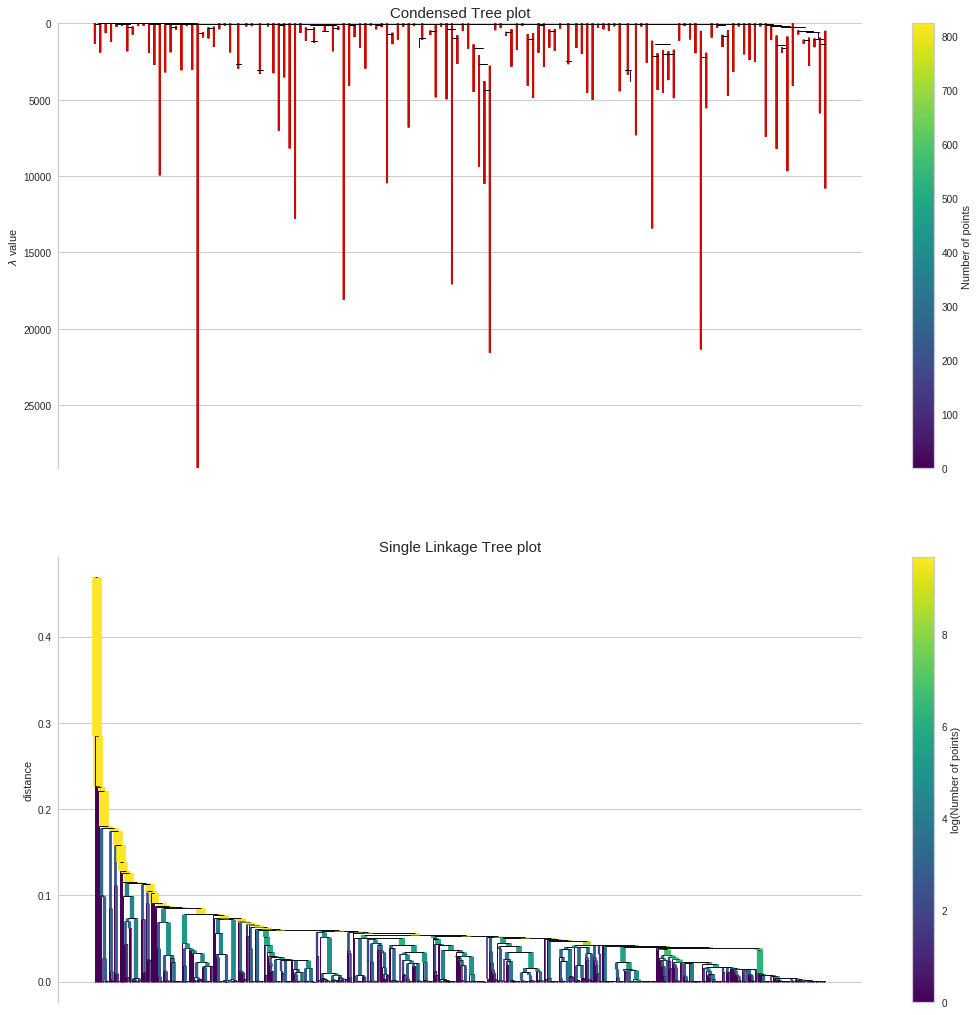

In [214]:
model = hdbscan.HDBSCAN(
    min_cluster_size= 3,
    min_samples= 2,
    cluster_selection_epsilon= 0.01
)

df['CLUSTER_hdbscan'] = model.fit_predict(df[['LAT','LON']])

plt.subplots(figsize=(18,18))

plt.subplot(2,1,1)
model.condensed_tree_.plot(select_clusters= True)
plt.title("Condensed Tree plot", fontdict= {'size':15})

plt.subplot(2,1,2)
model.single_linkage_tree_.plot()
plt.title("Single Linkage Tree plot", fontdict= {'size':15})

The two plots above show how the clusters initially taken have merged in heirarchial manner. The Condensed tree plot shows red lines which are actually circles identifying chosen optimal clusters. The Single linkage tree plot is a dendrogram and can also be used to determine optimal number of clusters, by selecting a cross section of the tallest vertical line and between that cross section, the number of vertical lines that lie are the optimal number of clusters.<br>

The min_cluster_size parameter denotes the minimum number of points required for a cluster to be considered as one after a split (top down approach) in the cluster. If after a split, one side doesnot fulfill this criteria, then those become outliers. For this use case, a value of 3 seems reasonable, If very close, a service center should atleast have 3 Taxi ranks within its service area, lesser than that would be a waste of resources. This parameter can be increased, based on unavailability of resources.

The next step is to evaluate the model, similar to how it was done in DBSCAN - by looking at the silhouettes score and plotting a map.

In [215]:
mapf = folium.Map(
    location= [df.LAT.mean(), df.LON.mean()],
    zoom_start= 9,
    tiles= 'Stamen Toner',
    height= 550
)

tmp = df.apply(
    lambda row: folium.CircleMarker(
        location= [row.LAT, row.LON],
        radius= 3,
        popup= row.CLUSTER_hdbscan,
        color= [colors[row.CLUSTER_hdbscan] if row.CLUSTER_hdbscan != -1 else '#00000F'],
        fill= True,
        fill_color= [colors[row.CLUSTER_hdbscan] if row.CLUSTER_hdbscan != -1 else '#00000F'],
    ).add_to(mapf),
    axis= 1
)
mapf

Immediately it can be noticed, that the number of outliers has now decreased, there are more clusters formed as compared to DBSCAN, which is good for the use case. Printing the details of this clustering below.

In [216]:
print(f'Number of clusters: {len(np.unique(df.CLUSTER_hdbscan))}')
print(f'Number of outliers/noise: {len(df[df.CLUSTER_hdbscan == -1])}')

pred = [(c+2)*x if x==-1 else x for c,x in enumerate(df.CLUSTER_hdbscan)]
print(f'Silhouette score with outliers as singletons: {silhouette_score(df[["LAT","LON"]], pred)}')

data = df[df.CLUSTER_hdbscan != -1]
print(f'Silhouette score without outliers: {silhouette_score(data[["LAT","LON"]],data.CLUSTER_hdbscan)}')

Number of clusters: 92
Number of outliers/noise: 70
Silhouette score with outliers as singletons: 0.7216846005477159
Silhouette score without outliers: 0.8106370154532011


The silhouette score for clusters considering outliers has increased from DBSCAN, this shows that HDBSCAN handled the outliers better and even reduced them considering local density rather than global density. The silhouette score without outliers has dropped, but it is still closer to 1 and hence still acceptable. The reason for the drop could be the increase in the number of clusters.

The HDBSCAN algorithm, has given a good number of clusters, but there are still outliers which need to be dealt with. Since the aim of the project is to find optimal locations and number of service centers to service Taxi ranks, the outliers need to be classified so a service center can be built, ignoring the outliers would disregard many Taxi ranks failing to provide a good service.<br>

To handle the outliers a simple Machine learning approach is used. For the outliers, a KNN algorithm is applied. It will consider clusters in the neighbouring out outliers and assign the outlier with the majority cluster vote. This is a fair enough estimate. Say for exmaple there is a group of Taxi ranks near the railway station, about 4 of them in and around. A Taxi rank about say 1 or 1.5 km away, an outlier can utilize the service center near the railway station rather than opening one near the outlier.

In [217]:
X_train = df.loc[df.CLUSTER_hdbscan != -1,['LAT','LON']]
y_train = df[df.CLUSTER_hdbscan != -1]['CLUSTER_hdbscan']

X_predict = df.loc[df.CLUSTER_hdbscan == -1,['LAT','LON']]

The classifier will be trained on already clustered points and then predictions will be made on the outliers. The n_neighbors is considered to be 3 here. (it can be changed based on need)

In [218]:
classifier = KNeighborsClassifier(n_neighbors= 3)
classifier.fit(X_train, y_train)

pred = classifier.predict(X_predict)

The predictions are stored in a separate column, hybrid of HDBSCAN and KNN. The outliers are classified using KNN and the rest remain the same.

In [219]:
df['CLUSTER_hybrid'] = df.CLUSTER_hdbscan
df.loc[df.CLUSTER_hdbscan == -1, 'CLUSTER_hybrid'] = pred

Similar to previous, the preditions are not plotted on a map and the silhouette score is reported.

In [220]:
mapf = folium.Map(
    location= [df.LAT.mean(), df.LON.mean()],
    zoom_start= 9,
    tiles= 'Stamen Toner',
    height= 550
)

tmp = df.apply(
    lambda row: folium.CircleMarker(
        location= [row.LAT, row.LON],
        radius= 3,
        popup= row.CLUSTER_hybrid,
        color= colors[row.CLUSTER_hybrid],
        fill= True,
        fill_color= colors[row.CLUSTER_hybrid],
    ).add_to(mapf),
    axis= 1
)
mapf

In [221]:
print(f'Silhouette score: {silhouette_score(df[["LAT","LON"]],df.CLUSTER_hybrid)}')

Silhouette score: 0.6654146388519125


The silhouette score has decreased as compared to using just HDBSCAN, but the outliers have been handled. The HDBSCAN + KNN, shows good cluster formations which can be used to understand where the service centers should be placed.<br>

To gather better understanding, the hybrid model is compared to the regular K-means model applied in the begining. For comparision purposes, the k-value of Kmeans is changed to 92, equal to hybrid model. A histogram is made of the cluster assignments.

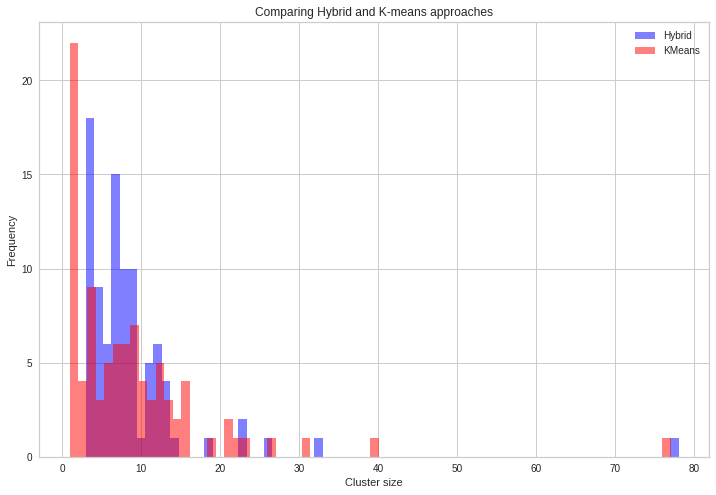

In [222]:
km = KMeans(n_clusters= 92, n_jobs= -1, verbose= 1, random_state= 5)
km.fit(np.array(df[['LAT','LON']], dtype= 'float64'))
df['CLUSTER_kmeans92'] = km.labels_

plt.figure(figsize= (12,8))
df.CLUSTER_hybrid.value_counts().plot.hist(bins= 70, label= 'Hybrid', alpha= 0.5, color= 'blue')
df.CLUSTER_kmeans92.value_counts().plot.hist(bins= 70, label= 'KMeans', alpha= 0.5, color= 'red')
plt.title('Comparing Hybrid and K-means approaches')
plt.xlabel('Cluster size')
plt.legend()

Kmeans shows that the cluster sizes are relatively smaller as compared to Hybrid. Basically this means that using HDBSCAN we took density based approach which clustered dense regions together. This is better than Kmeans because in a very dense region in terms of proximity, one service center is enough rather than 2 or 3 in close range. HDBSCAN + KNN = Hybrid has acheived this.<br>

The final step in the analysis, would be to suggest the approximate locations for the service centers, given the clusters found. Since HDBSCAN doesnot actuall return the cluster center, the assumption here is that the cluster center is the average of all points in the cluster.<br>
In the hybrid version, the outliers were classified into nearest clusters. If the outliers are considered for the average, the cluster center will shift from the main point of focus. The main idea of using HDBSCAN is to get dense clusters which would be beneficial. Thus for the average the clusters obtained from HDBSCAN are used, ignoring outliers rather than the Hybrid model.

In [233]:
service_center_loc = df.loc[
    df.CLUSTER_hdbscan != -1,
    ['LAT','LON','CLUSTER_hdbscan']
].groupby('CLUSTER_hdbscan').mean().reset_index()

mapf = folium.Map(
    location= [df.LAT.mean(), df.LON.mean()],
    zoom_start= 9,
    tiles= 'Stamen Toner',
    height= 550
)

tmp = service_center_loc.apply(
    lambda row: folium.CircleMarker(
        location= [row.LAT, row.LON],
        radius= 3,
        popup= row.CLUSTER_hdbscan,
        color= '#009999',
        fill= True,
        fill_color= '#009999'
    ).add_to(mapf),
    axis= 1
)
mapf

The above plot shows the estimated locations of the service centers based on the clusters formed. These locations are near optimal as they were approximated from dense clusters formed to reduce number of service centers as much as possible by assigning 1 in very dense regions and assigning outliers to one of these as well. These locations are the final output of the analysis and project.